<a href="https://colab.research.google.com/github/omiyawaki/miyawaki-2025-nonmonotonic-moist-adiabat/blob/main/Figure_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[2025-06-18 13:14:45] Starting buoyancy analysis plot generation...
[2025-06-18 13:14:45] Processing Ts = 280.0 K...
[2025-06-18 13:14:45] Processing Ts = 281.0 K...
[2025-06-18 13:14:45] Processing Ts = 282.0 K...
[2025-06-18 13:14:45] Processing Ts = 283.0 K...
[2025-06-18 13:14:45] Processing Ts = 284.0 K...
[2025-06-18 13:14:45] Processing Ts = 285.0 K...
[2025-06-18 13:14:45] Processing Ts = 286.0 K...
[2025-06-18 13:14:45] Processing Ts = 287.0 K...
[2025-06-18 13:14:45] Processing Ts = 288.0 K...
[2025-06-18 13:14:45] Processing Ts = 289.0 K...
[2025-06-18 13:14:45] Processing Ts = 290.0 K...
[2025-06-18 13:14:45] Processing Ts = 291.0 K...
[2025-06-18 13:14:45] Processing Ts = 292.0 K...
[2025-06-18 13:14:45] Processing Ts = 293.0 K...
[2025-06-18 13:14:45] Processing Ts = 294.0 K...
[2025-06-18 13:14:45] Processing Ts = 295.0 K...
[2025-06-18 13:14:45] Processing Ts = 296.0 K...
[2025-06-18 13:14:45] Processing Ts = 297.0 K...
[2025-06-18 13:14:45] Processing Ts = 298.0 K...
[

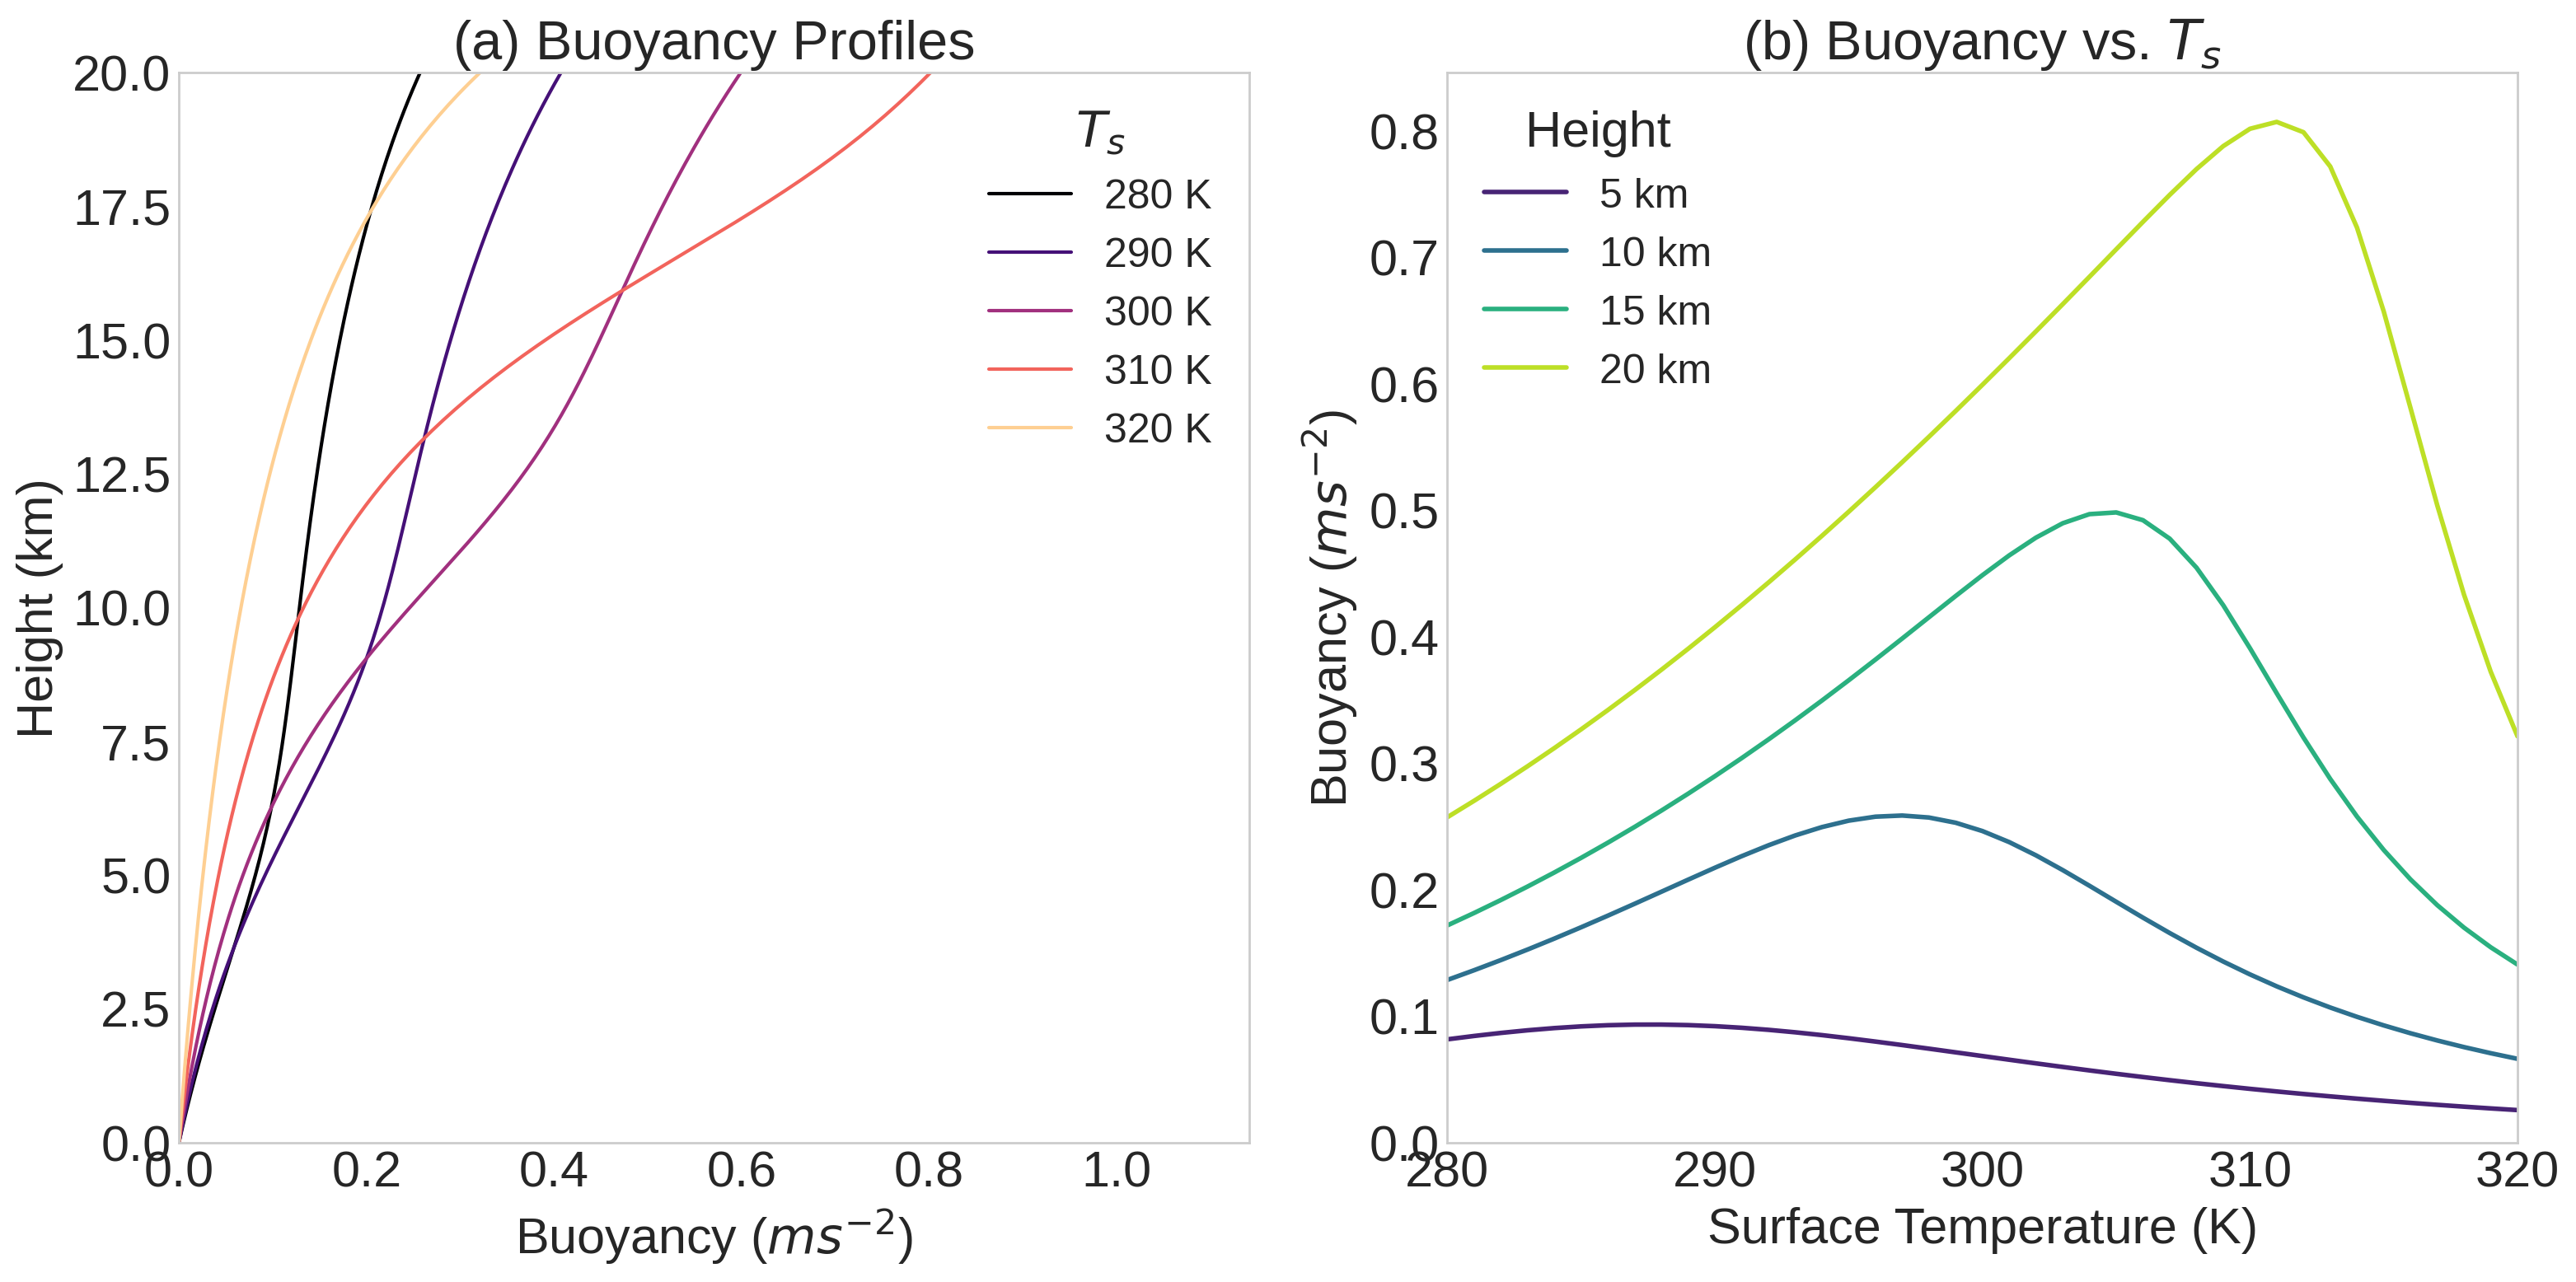

Figure 5 saved as figure_5_buoyancy_analysis.png


In [3]:
# ==============================================================================
# SCRIPT TO CREATE FIGURE 5:
# ANALYSIS OF NON-MONOTONIC BUOYANCY
#
# This script tests the hypothesis that the thermodynamic framework developed
# in this study can explain the non-monotonic buoyancy profiles documented in
# Romps (2016). It generates a two-panel figure for a comprehensive view:
# (a) Buoyancy profiles as a function of height, analogous to Romps' Fig 7.
# (b) Buoyancy at fixed heights as a function of surface temperature,
#    analogous to our previous warming analysis (Fig 1c).
#
# The script performs the following actions:
# 1. For a range of Ts (280-320 K), it computes an entraining "environment"
#    profile (a=0.2) and a non-entraining "parcel" profile (a=0).
# 2. It calculates the buoyancy profile B(z) from the temperature difference.
# 3. It generates the two-panel plot to visualize the non-monotonic behavior
#    of buoyancy both vertically (up to 20 km) and as a function of Ts.
# ==============================================================================

# For sharper inline plots in Jupyter environments
try:
    get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
except (NameError, AttributeError):
    pass

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.interpolate import interp1d
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
Lv_const = 2.501e6

# --- Core Thermodynamic & Profile Functions ---
def saturation_vapor_pressure(T):
    """Calculates saturation vapor pressure (es) in Pa."""
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (qs) in kg/kg."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    denominator = np.maximum(denominator, 1e-3)
    qs = epsilon * es / denominator
    return np.maximum(qs, 0.0)

def virtual_temperature(T, p):
    """Calculates virtual temperature (Tv) in K."""
    qs = saturation_specific_humidity(p, T)
    return T * (1.0 + (1.0 / epsilon - 1.0) * qs)

def calculate_entraining_mse(T, p, z, a):
    """Calculates Entraining Moist Static Energy (EMSE) from Romps (2016)."""
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv_const * qs / (1 + a)

def calculate_moist_adiabatic_profile(T_surf, p_surf, z_max, dz, a):
    """Calculates z, T, and p profiles by conserving EMSE for a given 'a'."""
    n_steps = int(z_max / dz) + 1
    z_profile = np.linspace(0, z_max, n_steps)
    T_profile, p_profile = np.full(n_steps, np.nan), np.full(n_steps, np.nan)
    T_profile[0], p_profile[0] = T_surf, p_surf
    mse_conserved = calculate_entraining_mse(T_profile[0], p_profile[0], 0.0, a)
    for i in range(n_steps - 1):
        z_c, T_c, p_c = z_profile[i], T_profile[i], p_profile[i]
        if np.isnan(T_c) or p_c <= 0: break
        z_n, Tv_c = z_profile[i+1], virtual_temperature(T_c, p_c)
        H = (Rd * Tv_c) / g
        p_n = p_c * np.exp(-dz / H)
        if p_n <= 0: break
        def res(T_g): return calculate_entraining_mse(T_g, p_n, z_n, a) - mse_conserved
        try:
            sol = root_scalar(res, bracket=[50.0, T_c + 5], method='brentq')
            if sol.converged: T_profile[i+1], p_profile[i+1] = sol.root, p_n
            else: break
        except (ValueError, RuntimeError): break
    valid = ~np.isnan(T_profile)
    return z_profile[valid], T_profile[valid], p_profile[valid]

def main():
    """Main function to execute the calculation and plotting."""
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Starting buoyancy analysis plot generation...")

    # --- Parameters ---
    P_SURFACE_PA = 100000.0
    Z_MAX_M = 25000 # Calculate up to 25km
    DZ_M = 100
    T_surf_range_K = np.arange(280, 320.1, 1.0)
    A_ENTRAIN = 0.2
    z_grid_m = np.arange(0, Z_MAX_M + DZ_M, DZ_M)
    z_grid_km = z_grid_m / 1000.0

    buoyancy_grid = np.full((len(z_grid_m), len(T_surf_range_K)), np.nan)

    # --- Calculation Loop ---
    for i, t_surf in enumerate(T_surf_range_K):
        print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Processing Ts = {t_surf:.1f} K...")

        z_env, t_env, _ = calculate_moist_adiabatic_profile(t_surf, P_SURFACE_PA, Z_MAX_M, DZ_M, a=A_ENTRAIN)
        z_par, t_par, _ = calculate_moist_adiabatic_profile(t_surf, P_SURFACE_PA, Z_MAX_M, DZ_M, a=0)

        if len(z_env) < 2 or len(z_par) < 2: continue

        interp_t_env = interp1d(z_env, t_env, bounds_error=False, fill_value=np.nan)
        interp_t_par = interp1d(z_par, t_par, bounds_error=False, fill_value=np.nan)

        t_env_grid = interp_t_env(z_grid_m)
        t_par_grid = interp_t_par(z_grid_m)

        delta_t = t_par_grid - t_env_grid
        buoyancy = g * delta_t / t_env_grid
        buoyancy[buoyancy < 0] = 0
        buoyancy_grid[:, i] = buoyancy

    # --- Visualization ---
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Calculation complete. Generating plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    base_fontsize = 22

    # --- Panel (a): Buoyancy Profiles ---
    ax1 = axes[0]
    T_plot_values = [280, 290, 300, 310, 320]
    cmap = plt.get_cmap('magma')
    colors = cmap(np.linspace(0, 0.9, len(T_plot_values)))
    for i, t_surf_val in enumerate(T_plot_values):
        t_idx = np.argmin(np.abs(T_surf_range_K - t_surf_val))
        buoyancy = buoyancy_grid[:, t_idx]
        ax1.plot(buoyancy, z_grid_km, color=colors[i], label=f'{t_surf_val} K')

    ax1.set_xlabel('Buoyancy ($m s^{-2}$)', fontsize=base_fontsize)
    ax1.set_ylabel('Height (km)', fontsize=base_fontsize)
    ax1.set_title('(a) Buoyancy Profiles', fontsize=base_fontsize+2)
    ax1.legend(title='$T_{s}$', title_fontsize=base_fontsize, fontsize=base_fontsize-4)
    ax1.tick_params(axis='both', which='major', labelsize=base_fontsize)
    ax1.set_ylim(0, 20)
    ax1.set_xlim(left=0)
    ax1.grid(False)
    ax1.set_box_aspect(1)


    # --- Panel (b): Buoyancy at fixed heights ---
    ax2 = axes[1]
    z_levels_km = [5, 10, 15, 20]
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0.1, 0.9, len(z_levels_km)))

    for i, z_km in enumerate(z_levels_km):
        z_idx = np.argmin(np.abs(z_grid_km - z_km))
        ax2.plot(T_surf_range_K, buoyancy_grid[z_idx, :], color=colors[i], label=f'{z_km} km', linewidth=2)

    ax2.set_xlabel('Surface Temperature (K)', fontsize=base_fontsize)
    ax2.set_ylabel('Buoyancy ($m s^{-2}$)', fontsize=base_fontsize)
    ax2.set_title('(b) Buoyancy vs. $T_{s}$', fontsize=base_fontsize+2)
    ax2.legend(title='Height', title_fontsize=base_fontsize, fontsize=base_fontsize-4)
    ax2.tick_params(axis='both', which='major', labelsize=base_fontsize)
    ax2.set_xlim(280, 320)
    ax2.set_ylim(bottom=0)
    ax2.grid(False)
    ax2.set_box_aspect(1)

    plt.tight_layout(pad=2.0)
    fig5_filename = "fig-5.png"
    plt.savefig(fig5_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Figure 5 saved as {fig5_filename}")

if __name__ == '__main__':
    main()
